<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/Iterations_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=322ea366137adffdcfbcb0dcfc95c2b2001dd201880eff072a39eddceede3006
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv("peopleperroomnormalized_with_winners_cleaned2024.csv")
# data = data.drop(columns=['Aged 15 years and under'])


filtered_data = data[data['Winning Party'].isin(['Labour', 'Conservative'])]

party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    # 'Liberal Democrat': (1, 0.65, 0),  # Orange
    # 'Green': (0, 0.5, 0),         # Dark Green
    # 'The Brexit Party': (0.8, 0.4, 0), #light blue
    #  'Reform UK': (0, 0, 0.5), # Dark Blue


}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = filtered_data.drop(columns=labeling_columns)

#Feature Scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# robust_scaler = RobustScaler()
# normalized_features = robust_scaler.fit_transform(features)


#Spliting the data in to training, validation and test
train_data, validation_data = train_test_split(normalized_features, test_size=0.3, random_state=42)
# validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)



print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
# print(f"Test set: {test_data.shape}")

# normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
# normalized_df[labeling_columns] = data[labeling_columns]

# print(normalized_df.head())

Training set: (219, 4)
Validation set: (95, 4)


 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.046621537591905585
Iteration 500: Train Error = 0.046621537591905585, Validation Error = 0.05322934504200257
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.04429324141105224
Iteration 1000: Train Error = 0.04429324141105224, Validation Error = 0.054306225912869585
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.04472241845229798
Iteration 1500: Train Error = 0.04472241845229798, Validation Error = 0.05296346322738715
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.044408231166800184
Iteration 2000: Train Error = 0.044408231166800184, Validation Error = 0.05154177812084542
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.04314983169964143
Iteration 2500: Train Error = 0.04314983169964143, Validation Error = 0.050368021230539066
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.04174753012744258
Iteration 3000: Train Error = 0.04174753012744258, Validation Error = 0.05106468857

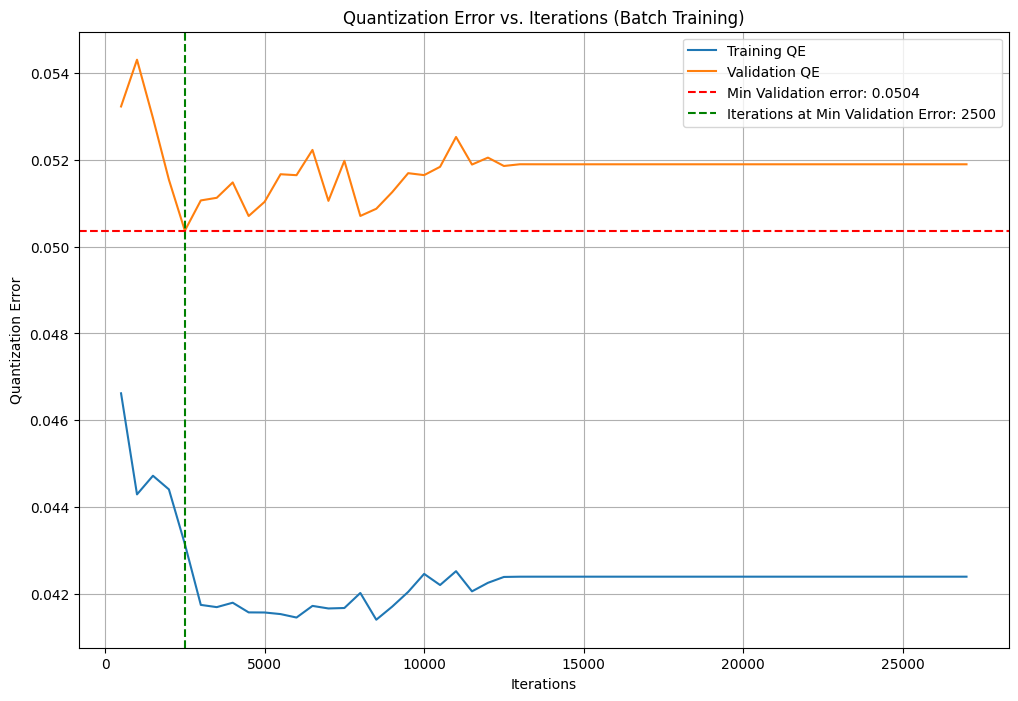

In [ ]:
n_neurons = int(np.sqrt(5 * np.sqrt(train_data.shape[0])))
m_neurons = n_neurons

som = MiniSom(n_neurons, m_neurons, train_data.shape[1], sigma=1.07555, learning_rate=0.436,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')

som.random_weights_init(train_data)

# Track quantization errors
train_errors = []
validation_errors = []


# Define range of iterations
max_iterations = 26650 #started with 266500 which is approximately 50 epochs and is the rule of thumb for mid-sized datasets. However, the Qe plateaued by 10,000 iterations which is 20 epochs
batch_size = 500 # Check the Qe after every 500 iterations
# num_batches = max_iterations // batch_size # Total number of batches

for iterations in range(0, max_iterations, batch_size):

  som.train(train_data, num_iteration=batch_size, verbose=True)


  train_error = som.quantization_error(train_data)
  validation_error = som.quantization_error(validation_data)
  train_errors.append(train_error)
  validation_errors.append(validation_error)
  print(f"Iteration {iterations+batch_size}: Train Error = {train_error}, Validation Error = {validation_error}")



iterations = np.arange(batch_size, max_iterations + batch_size, batch_size)
plt.figure(figsize=(12, 8))
plt.plot(iterations, train_errors, label='Training QE')
plt.plot(iterations, validation_errors, label='Validation QE')
plt.xlabel('Iterations')
plt.ylabel('Quantization Error')
plt.axhline(y=min(validation_errors), color='red', linestyle='--', label=f"Min Validation error: {min(validation_errors):.4f}")
plt.axvline(x=iterations[np.argmin(validation_errors)], color='green', linestyle='--', label=f"Iterations at Min Validation Error: {iterations[np.argmin(validation_errors)]}")

plt.title('Quantization Error vs. Iterations (Batch Training)')
plt.legend()
plt.grid(True)
plt.show()



